In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#default_exp core

In [ ]:
from nbdev import *

# Core
> core functionality used in nnanno

## Imports

In [ ]:
#export
import math
import pathlib
from pathlib import Path
import PIL
from PIL import Image, UnidentifiedImageError
import io
import pandas as pd
import multiprocessing
import requests
import requests_cache
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from typing import (
    Any,
    Optional,
    Union,
    Dict,
    List,
    Tuple,
    Set,
    Iterable,
)

### Requests 

In [ ]:
#export
def create_session():
    retry_strategy = Retry(total=80)
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session = requests.Session()
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

`create_session` creates a requests session. We add a `Retry` to allow for a bit more resilience

In [ ]:
#hide
session = create_session()
assert type(session) == requests.sessions.Session

#### Cached requests
We might want to request the same data from the Newspaper Navigator Dataset multiple times, i.e. if we want to generate different sized samples. This isn't ideal since it takes time for us to wait for the response and money for the LOC to serve those responses. `nnanno` uses caching for **most** requests to the Newspaper Navigator dataset. When a request is made to a url for the first time it is requested and returned in the usual way. If that same url is requested again it will be returned from a cache. 

This is done by using the [requests_cache](https://github.com/reclosedev/requests-cache) library. `requests_cache` creates a [sqlite](https://www.sqlite.org/index.html) database to store the cached requests. 

This database `url_cache.sqlite` will grow as you request more urls from the Newspaper Navigator dataset. Some requests are too big for sqlite to ingest (ads beyond 1870 and headlines). The size of the datbase when all other requests are cached is # TODO check db size

In [ ]:
#export
def create_cached_session():
    """Creates a session which creates a cache of requests"""
    retry_strategy = Retry(total=80)
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session = requests_cache.core.CachedSession('url_cache')
    session.mount('http://',adapter)
    return session

`create_cached_session` creates a session which returns cached results if url has been previously requested. This cache is stored in an sqlite database `url_cache.sqlite`

In [ ]:
session = create_cached_session()
r = session.get("https://google.com")
r.status_code, r.from_cache

(200, True)

In [ ]:
#hide
s = create_cached_session()
r = s.get("https://google.com")
assert r.from_cache == True

## Multiprocessing
Quite a few of the things done by nnanno can be done in parallel. A crude heurisitc for defining the max number of workers is based on the cpu count and length of data. 

In [ ]:
#export
def get_max_workers(data=None) -> int:
    """
    Returns int to pass to max_workers based on len of `data` if available or `cpu_count()`
    """
    if data is not None and hasattr(data, '__len__'):
        return min(multiprocessing.cpu_count(), len(data))
    else:
        return multiprocessing.cpu_count()

`get_max_workers` returns the `min` of the cpu count or `len` of the data. This isn't used everywhere and is a fairly crude heuristic. 

In [ ]:
list_data = [1,2,3,4]
get_max_workers(list_data), get_max_workers()

(4, 8)

In [ ]:
#hide
gen_data = iter(range(4))
assert get_max_workers(gen_data) == multiprocessing.cpu_count()
list_data = [1,2,3,4]
assert get_max_workers(list_data) == min(multiprocessing.cpu_count(), len(list_data))
df = pd.DataFrame(list_data)
assert get_max_workers(df) == min(multiprocessing.cpu_count(),4)

## Images
This code deals with loading, saving and downloading images. 

### Loading

In [ ]:
#export
def load_url_image(url: str, mode='RGB') -> Union[PIL.Image.Image,None]:
    """Attempts to load an image from `url` returns `None` if request times out or no image at url"""
    im = None
    session = create_session()
    with session.get(url, timeout=(30)) as r:
        if r:
            try:
                im = (Image.open(io.BytesIO(r.content))).convert(mode)
            except PIL.UnidentifiedImageError:
                pass
        return im

`load_url_image` loads an image from a URL if available and returns it as a `PIL Image` in `RGB` "mode by default i.e. 3 channels. Since we might have some url timeouts etc. from time to time, it will return `None` if it doesn't find an image or the requests has a timeout. This means downstream function will usually want to check for and handle `None` as well as `PIL Images`

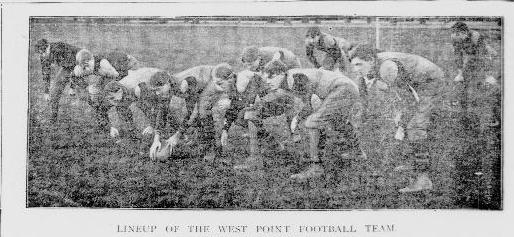

In [ ]:
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url);im

In [ ]:
#hide
test_bad_url = 'https://chroniclingamerica.loc.gov/data/batches/msar_icydrop_ver05/data/sn83016872/00295878502/1850123101/098'
test_page_url = 'https://chroniclingamerica.loc.gov/data/batches/msar_icydrop_ver05/data/sn83016872/00295878502/1850123101/0986.jp2'
assert load_url_image(test_bad_url) == None
assert type(load_url_image(test_page_url)) == PIL.Image.Image
assert load_url_image(test_page_url).mode == 'RGB'

### Casting to RGB
Not used at the moment but we may sometimes want to enforce all `PIL Images` to `RGB` mode to avoid tensor mismatches between different images shapes. 

#### Note 
I haven't looked closely at the impact of casting to `RGB` versus using grayscale images for machine learning. Since we don't loose information by casting to `RGB` this is probably a sensible starting point, especially as I am assuming images loaded will usually be used as part of a deep learning pipeline that involves transfer learning from images trained on three channels. There is some experimentation/research to be done on the best way of handling this to be done. 

\ # TODO Reading and experiments on best way/need to deal with grayscale vs 3 channel images using transfer learning. 

In [ ]:
def _to_rgb(images):
    rgb_images = []
    for im in images:
        rgb_images.append(im.convert('RGB'))
    return rgb_images

In [ ]:
# hide
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
imL = load_url_image(url,mode='L'); L_images = [imL for i in range(32)]
assert set([im.mode for im in _to_rgb(L_images)]) == {'RGB'}
assert len(set([im.mode for im in _to_rgb(L_images)])) == 1

### Saving images


In [ ]:
#export
def save_image(im: PIL.Image.Image, fname: str, out_dir:Union[str, pathlib.Path] = '.'):
    """Saves `im` as `fname` to `out_dir`"""
    out_path = Path(f'{out_dir}/{fname}')
    im.save(out_path)

`save_image` saves an image `im` to filename `fname` and directory `out_dir`. 

In [ ]:
im = Image.open(io.BytesIO(requests.get(url).content))
save_image(im, 'test_iif.jpg')

In [ ]:
#hide
im = Image.open(io.BytesIO(requests.get(url).content))
save_image(im, 'test_iif.jpg')
assert (Path('test_iif.jpg').exists()) == True
assert type(Image.open('test_iif.jpg')) == PIL.JpegImagePlugin.JpegImageFile
Path('test_iif.jpg').unlink()

### Downloading images

In [ ]:
#export
def download_image(url: str, fname: str, out_dir:Union[str, pathlib.Path] ='.') -> None:
    """
    Attempts to load image from `url` and save as `fname` to `out_dir`
    Returns `None` if bad URL or request timesout
    """
    im = load_url_image(url)
    if im:
        save_image(im, fname, out_dir)
    else:
        return None

Combines `load_url_image` and `save_image` 

In [ ]:
#hide
download_image(url, 'test_iif.jpg')
assert (Path('test_iif.jpg').exists()) == True
assert type(Image.open('test_iif.jpg')) == PIL.JpegImagePlugin.JpegImageFile
Path('test_iif.jpg').unlink()
bad_url = 'http://google.com'
assert download_image(bad_url,'bad_url.jpg') is None
assert (Path('bad_url.jpg').exists()) == False

### IIIF

The Image Interoperability Framework (IIIF, pronounced “Triple-Eye-Eff”), is a lovely api for requesting images. 

We can utilise IIIF to download images from the Newspaper Navigator dataset because the API allows you to specify a region. As a bonus we can also specify a bunch of other useful things in our request such as size which will help ensure we only download the size of image we actually need. Thanks to Benjamin Lee for pointing out this API and for the code in # TODO add link to newspaper navigator search 

In [ ]:
#export
def parse_box(box: List) -> Tuple[float, float, float,float]:
    """Parses the `box` value from Newspaper Navigator data to prepre for IIIF request"""
    box_x1, box_x2, box_y1, box_y2 = box
    x = math.floor(box_x1*10000)/100.
    y = math.ceil(box_x2*10000)/100.
    w = math.ceil((box_y1 - box_x1)*10000)/100.
    h = math.ceil((box_y2 - box_x2)*10000)/100.
    return x, y, w, h

In [ ]:
box = [0.2624743069, 0.0310959541, 0.9860676740000001, 0.2558741574]
parse_box(box)

(26.24, 3.11, 72.36, 22.48)

In [ ]:
#export
def create_iiif_url(box:Union[Tuple,List],
                    url:str,
                    original:bool=False,
                    pct:int=None,
                    size:tuple=None,    # TODO make size a height and a width
                    preserve_asp_ratio:bool=True
                   )->str:
    """Returns a IIIF URL from bounding box and url"""

    # TODO refactor to use string formating and tidy if else statements
    x, y, w, h = parse_box(box)
    url_coordinates = "pct:" + str(x) + "," + str(y) + "," + str(w) + "," + str(h)
    url_chronam_path = "%2F".join(url.split("/")[4:10]) + ".jp2"

    url_prefix = "https://chroniclingamerica.loc.gov/iiif/2"
    url_suffix_full = "pct:100/0/default.jpg"
    pct_downsampled = f"pct:{pct}/0/default.jpg"

    if original and not size and not pct:
        return "/".join([url_prefix, url_chronam_path, url_coordinates, url_suffix_full])
    if pct:
        return  "/".join([url_prefix, url_chronam_path, url_coordinates, pct_downsampled])
    if size and preserve_asp_ratio:
        return "/".join([url_prefix, url_chronam_path, url_coordinates,  f"!{size[0]},{size[1]}/0/default.jpg"])
    if size and not preserve_asp_ratio:
        return "/".join([url_prefix, url_chronam_path, url_coordinates,  f"{size[0]},{size[1]}/0/default.jpg"])

In [ ]:
box = [0.2624743069, 0.0310959541, 0.9860676740000001, 0.2558741574]
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'

https://chroniclingamerica.loc.gov/iiif/2/dlc_fiji_ver01%2Fdata%2Fsn83030214%2F00175040936%2F1900102801%2F0519.jp2/pct:26.24,3.11,72.36,22.48/pct:10/0/default.jpg


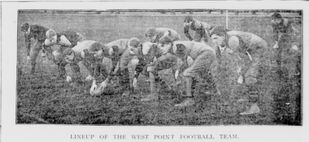

In [ ]:
iiifurl = create_iiif_url(box, url, pct=10)
print(iiifurl);load_url_image(iiifurl)

In [ ]:
#hide
im = Image.open(io.BytesIO(requests.get(iiifurl).content))
assert type(im) == PIL.JpegImagePlugin.JpegImageFile

In [ ]:
#export
def iiif_df_apply(
    row,
    original: bool = False,
    pct: int = 50,
    size: tuple = None,
    preserve_asp_ratio: bool = True,
):
    """Creates IIIF urls from a pandas DataFrame containing newspaper navigator data"""
    return create_iiif_url(
        row["box"],
        row["url"],
        original=original,
        pct=pct,
        size=size,
        preserve_asp_ratio=preserve_asp_ratio,
    )

## Convenience 

In [ ]:
# export 
def bytesto(bytes, to: str, bsize:int=1024) -> float:
    """Takes bytes and returns value convereted to `to`"""
    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    return bytes / (bsize ** a[to])

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
